### CBLOF 處理竊電

- 前處理參考："An Ensemble Deep Convolutional Neural Network Model for Electricity Theft Detection in Smart Grids"
- 方法參考：Electricity Theft Detection in AMI Based on Clustering and Local Outlier Factor
- 使用套件：from pyod.models.cblof import CBLOF

前處理
- 遺失值：週的方式
- 離群值： Winsorization 方法
- 標準化： 對所有資料，而非每個用戶（列）
- 不平行處理： random under bagging

輸入的檔案(已經完成 missing 的處理，剩下的前處理在下方程式碼）
- df_train_all_recov.csv
- df_test_all_recov.csv

訓練好的 model
- clof_model.joblib

### ------------------------------------------------------------------------------------------

### <font color=#4169e1>Import Library</font>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from pyod.models.cblof import CBLOF
from pyod.utils.data import evaluate_print
# from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.cluster import DBSCAN
# from sklearn.cluster import KMeans

- Save Model: pip install joblib
- CBLOF library: pip install pyod

### <font color=#4169e1>01. Load Data</font>

In [ ]:
# 讀取數據
file_path = '/Users/ranli/Desktop/weekly_nan/df_train_all_recov.csv'
df_ori = pd.read_csv(file_path)

# 移除Unnamed: 0列
df_ori = df_ori.drop(columns=['Unnamed: 0'])

print(df_ori.head())

                            CONS_NO  FLAG  2014-01-01 00:00:00  \
0  0387DD8A07E07FDA6271170F86AD9151     1                 -1.0   
1  01D6177B5D4FFE0CABA9EF17DAFC2B84     1                 -1.0   
2  4B75AC4F2D8434CFF62DB64D0BB43103     1                 -1.0   
3  B32AC8CC6D5D805AC053557AB05F5343     1                 -1.0   
4  EDFC78B07BA2908B3395C4EB2304665E     1                  2.9   

   2014-01-02 00:00:00  2014-01-03 00:00:00  2014-01-04 00:00:00  \
0                -1.00                -1.00                -1.00   
1                -1.00                -1.00                -1.00   
2                -1.00                -1.00                -1.00   
3                -1.00                -1.00                -1.00   
4                 5.64                 6.99                 3.32   

   2014-01-05 00:00:00  2014-01-06 00:00:00  2014-01-07 00:00:00  \
0                -1.00                -1.00                -1.00   
1                -1.00                -1.00               

In [ ]:
df = df_ori

In [ ]:
df.shape

(42222, 1038)

<font color=#f4a460> 標準化測試 </font>

In [ ]:
# 定義 Min-Max 標準化方法，針對整個數據集
def min_max_scale_dataframe(df):
    # 計算最小值和最大值
    min_val = df.min().min()
    max_val = df.max().max()

    # 應用 Min-Max 標準化公式
    df_scaled = (df - min_val) / (max_val - min_val)

    return df_scaled

In [ ]:
import numpy as np

# 創建一個測試數據集
data = {
    'ID': [1, 2, 3, 4, 5],
    'Name': ['A', 'B', 'C', 'D', 'E'],
    'Feature1': [-1, 20, 30, 40, 99],
    'Feature2': [50, 40, 30, 0, 10]
}

df_2 = pd.DataFrame(data)
print("原始數據集:")
print(df_2)

# 對數據集中的特徵列進行 Min-Max 標準化
df_2.iloc[:, 2:] = min_max_scale_dataframe(df_2.iloc[:, 2:])
print("\n標準化後的數據集:")
print(df_2)

# 驗證標準化結果是否在 [0, 1] 範圍內
assert np.all(df_2.iloc[:, 2:] >= 0) and np.all(df_2.iloc[:, 2:] <= 1), "標準化失敗，存在超出範圍的值"
print("\n測試通過，所有值均在 [0, 1] 範圍內。")

原始數據集:
   ID Name  Feature1  Feature2
0   1    A        -1        50
1   2    B        20        40
2   3    C        30        30
3   4    D        40         0
4   5    E        99        10

標準化後的數據集:
   ID Name  Feature1  Feature2
0   1    A      0.00      0.51
1   2    B      0.21      0.41
2   3    C      0.31      0.31
3   4    D      0.41      0.01
4   5    E      1.00      0.11

測試通過，所有值均在 [0, 1] 範圍內。


/var/folders/7w/3s6n9zms07b59z55xbgsjh7w0000gn/T/ipykernel_79592/4042012127.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0    0.00
1    0.21
2    0.31
3    0.41
4    1.00
Name: Feature1, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_2.iloc[:, 2:] = min_max_scale_dataframe(df_2.iloc[:, 2:])
/var/folders/7w/3s6n9zms07b59z55xbgsjh7w0000gn/T/ipykernel_79592/4042012127.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0    0.51
1    0.41
2    0.31
3    0.01
4    0.11
Name: Feature2, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_2.iloc[:, 2:] = min_max_scale_dataframe(df_2.iloc[:, 2:])


### <font color=#4169e1>02. Data Pre-process</font>

In [ ]:
# 定義 Min-Max 標準化方法，針對整個數據集
def min_max_scale_dataframe(df):
    # 計算最小值和最大值
    min_val = df.min().min()
    max_val = df.max().max()

    # 應用 Min-Max 標準化公式
    df_scaled = (df - min_val) / (max_val - min_val)

    return df_scaled

In [ ]:
# 定義Winsorization方法
def winsorize_dataframe(df, lower_percentile=0.05, upper_percentile=0.95):
    return df.apply(lambda x: np.clip(x, x.quantile(lower_percentile), x.quantile(upper_percentile)), axis=1)

# def winsorize_dataframe(df, upper_percentile=0.95):
#     upper_bound = df.quantile(upper_percentile)
#     return df.apply(lambda x: np.minimum(x, upper_bound), axis=1)

# 應用Winsorization到數據框中每個用戶
df.iloc[:, 2:] = winsorize_dataframe(df.iloc[:, 2:])


# # 定義Min-Max標準化方法，針對每一列（行）
# def min_max_scale_dataframe(df):
#     scaler = MinMaxScaler()
#     # 轉置DataFrame，使得每一行變成每一列
#     df_transposed = df.T
#     # 對轉置後的DataFrame應用標準化
#     df_transposed_scaled = pd.DataFrame(scaler.fit_transform(df_transposed), columns=df_transposed.columns, index=df_transposed.index)
#     # 再次轉置回原來的形狀
#     df_scaled = df_transposed_scaled.T
#     return df_scaled

# # 應用Min-Max標準化到數據框中每個用戶（針對列）
# df.iloc[:, 2:] = min_max_scale_dataframe(df.iloc[:, 2:])

# 標準化
df.iloc[:, 2:] = min_max_scale_dataframe(df.iloc[:, 2:])


# Random Under Bagging
def random_under_bagging(df, label_column='FLAG', n_bags=15):
    df_majority = df[df[label_column] == 0]
    df_minority = df[df[label_column] == 1]

    bags = []
    for _ in range(n_bags):
        df_majority_downsampled = resample(df_majority,
                                           replace=False,
                                           n_samples=len(df_minority),
                                           random_state=np.random.randint(10000))
        df_bag = pd.concat([df_majority_downsampled, df_minority])
        bags.append(df_bag)

    return bags

# 假設 'FLAG' 列存在並標記正常用戶為0，盜電用戶為1
bags = random_under_bagging(df, label_column='FLAG')

In [ ]:
# 計算 MAP 的函數
def mean_average_precision(y_true, y_scores, R):
    df = pd.DataFrame({'y_true': y_true, 'y_scores': y_scores})
    df = df.sort_values(by='y_scores', ascending=False).head(R)
    df['precision'] = df['y_true'].cumsum() / (np.arange(len(df)) + 1)
    return df['precision'][df['y_true'] == 1].mean()

<font color=#f4a460> 不要印出來看（很久） </font>

In [ ]:
# # 定義Winsorization方法
# def winsorize_series(series, lower_percentile=0.05, upper_percentile=0.95):
#     lower_limit = series.quantile(lower_percentile)
#     upper_limit = series.quantile(upper_percentile)
#     print(f"Row Index: {series.name}, Lower Limit: {lower_limit}, Upper Limit: {upper_limit}")
#     return np.clip(series, lower_limit, upper_limit)

# # 對每一列應用Winsorization方法
# for index, row in df.iterrows():
#     df.loc[index, df.columns[2:]] = winsorize_series(row[df.columns[2:]])

Row Index: 0, Lower Limit: -1.0, Upper Limit: 26.52


Row Index: 1, Lower Limit: -1.0, Upper Limit: 0.0
Row Index: 2, Lower Limit: -1.0, Upper Limit: 14.178999999999998
Row Index: 3, Lower Limit: -1.0, Upper Limit: 27.530999999999988
Row Index: 4, Lower Limit: 3.3569999999999998, Upper Limit: 19.932999999999993
Row Index: 5, Lower Limit: -1.0, Upper Limit: 4.845999999999999
Row Index: 6, Lower Limit: 0.0, Upper Limit: 5.108999999999998
Row Index: 7, Lower Limit: 0.52, Upper Limit: 5.872999999999999
Row Index: 8, Lower Limit: -1.0, Upper Limit: 10.119999999999996
Row Index: 9, Lower Limit: -1.0, Upper Limit: 35.281299999999945
Row Index: 10, Lower Limit: -1.0, Upper Limit: 4.89
Row Index: 11, Lower Limit: -1.0, Upper Limit: 15.088999999999999
Row Index: 12, Lower Limit: -1.0, Upper Limit: 18.833999999999996
Row Index: 13, Lower Limit: 4.361, Upper Limit: 28.383999999999997
Row Index: 14, Lower Limit: 0.0, Upper Limit: 9.771999999999993
Row Index: 15, Lower Limit: -1.0, Upper Limit: 17.816
Row Index: 16, Lower Limit: 7.624, Upper Limit: 20.

KeyboardInterrupt: 

### <font color=#4169e1>03. Train & Evaluation</font>

In [ ]:
# 初始化評估指標的列表
roc_aucs = []
precisions = []
recalls = []
f1_scores = []
map_score = []

# 對每個bag進行訓練和評估
for i, train_df in enumerate(bags):
    # 分離特徵和標籤
    X_train = train_df.drop(columns=['CONS_NO', 'FLAG'])
    y_train = train_df['FLAG']

    # 訓練CLOF模型
    clof = CBLOF(n_clusters=1000, beta=50)
    clof.fit(X_train)

    # 預測
    y_train_pred = clof.labels_
    y_train_scores = clof.decision_scores_

    # 評估模型
    roc_auc = roc_auc_score(y_train, y_train_scores)
    precision = precision_score(y_train, y_train_pred)
    recall = recall_score(y_train, y_train_pred)
    f1 = f1_score(y_train, y_train_pred)
    map = mean_average_precision(y_train, y_train_scores, R=50)

    # 將評估結果添加到列表中
    roc_aucs.append(roc_auc)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    map_score.append(map)


    print(f'Bag {i+1} - AUC: {roc_auc}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}, MAP@50 Score:{map}')
    # 使用PyOD的evaluate_print方法打印評估結果
    evaluate_print('CLOF', y_train, y_train_scores)

# 計算平均評估結果
mean_roc_auc = np.mean(roc_aucs)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1 = np.mean(f1_scores)
mean_map_score = np.mean(map_score)

print(f'Average AUC: {mean_roc_auc}')
print(f'Average Precision: {mean_precision}')
print(f'Average Recall: {mean_recall}')
print(f'Average F1 Score: {mean_f1}')
print(f'Average MAP@50: {mean_map_score}')

Bag 1 - AUC: 0.6743957952805837, Precision: 0.8298465829846583, Recall: 0.16596931659693165, F1 Score: 0.2766155276615528, MAP@50 Score:0.9843895137297431
CLOF ROC:0.6744, precision @ rank n:0.6243
Bag 2 - AUC: 0.6669716722201797, Precision: 0.8340306834030683, Recall: 0.16680613668061367, F1 Score: 0.2780102278010228, MAP@50 Score:0.9816027412002909
CLOF ROC:0.667, precision @ rank n:0.6198
Bag 3 - AUC: 0.6767707147984103, Precision: 0.8451882845188284, Recall: 0.16903765690376568, F1 Score: 0.28172942817294283, MAP@50 Score:0.950435421888586
CLOF ROC:0.6768, precision @ rank n:0.6209
Bag 4 - AUC: 0.6631221831239338, Precision: 0.8186889818688982, Recall: 0.16373779637377964, F1 Score: 0.27289632728963276, MAP@50 Score:0.9690258276907627
CLOF ROC:0.6631, precision @ rank n:0.6137
Bag 5 - AUC: 0.6625761298140984, Precision: 0.810320781032078, Recall: 0.16206415620641562, F1 Score: 0.2701069270106927, MAP@50 Score:0.991624344641023
CLOF ROC:0.6626, precision @ rank n:0.61
Bag 6 - AUC: 0

In [ ]:
# 查看小集群和大集群 (看 beta 參數的調整)
small_clusters = clof.small_cluster_labels_
large_clusters = clof.large_cluster_labels_

print("Small Clusters: ", small_clusters)
print("Large Clusters: ", large_clusters)

Small Clusters:  [546 548 549 550 551 552 554 555 556 557 559 560 561 997 562 996 564 565
 567 593 595 596 597 627 628 629 630 631 632 633 634 635 989 637 638 639
 640 641 642 643 644 645 626 988 625 621 598 599 994 601 993 604 606 607
 608 609 610 615 616 617 992 991 618 619 620 693 694 737 696 959 860 958
 861 862 863 864 865 866 858 868 870 871 872 873 957 875 876 878 879 869
 956 960 853 824 825 827 828 829 831 832 835 962 856 837 840 841 842 843
 844 846 847 849 961 839 823 881 885 914 915 916 918 919 920 921 922 924
 913 925 931 934 951 936 940 943 944 946 947 929 883 910 909 886 887 889
 891 892 893 894 895 955 952 896 954 899 901 953 902 903 905 906 907 897
 820 819 817 729 732 733 734 735 736 949 740 742 728 744 746 747 750 751
 753 755 545 758 972 745 760 727 725 697 698 980 699 700 701 702 703 707
 726 979 710 978 713 714 718 719 720 722 976 708 761 971 762 793 795 796
 797 798 799 800 802 804 792 805 807 808 809 964 812 813 814 963 816 965
 790 788 787 763 764 970 765 969 7

### 參數調整的影響：

- alpha：減小 alpha 值會增加小集群的數量，這可能會增加誤報率；增大 alpha 值會減少小集群的數量，這可能會增加漏報率。
- beta：增大 beta 值會減少小集群的數量，這可能會減少誤報；減小 beta 值會增加小集群的數量，這可能會增加誤報。

<font color=#f4a460> Save Model </font>

In [ ]:
# 保存模型到文件
joblib.dump(clof, '/Users/ranli/Documents/python_ve/MS_BDA/weekly_nan_test/clof_model.joblib')

['/Users/ranli/Documents/python_ve/MS_BDA/weekly_nan_test/clof_model.joblib']

### <font color=#4169e1> 04. 計算異常值分數（anomaly_score）以及排序（前 50 個）</font>
- 這邊先使用 train  查看排序和實際是否偷電的關係

In [ ]:
# 定義數據前處理的函數
def preprocess_data(df):
    # 移除Unnamed: 0列
    df = df.drop(columns=['Unnamed: 0'])

    # 定義Winsorization方法
    def winsorize_dataframe(df, lower_percentile=0.05, upper_percentile=0.95):
        return df.apply(lambda x: np.clip(x, x.quantile(lower_percentile), x.quantile(upper_percentile)), axis=1)

    # def winsorize_dataframe(df, upper_percentile=0.9):
    #     upper_bound = df.quantile(upper_percentile)
    #     return df.apply(lambda x: np.minimum(x, upper_bound), axis=1)

        # 應用Winsorization到數據框中每個用戶
    df.iloc[:, 2:] = winsorize_dataframe(df.iloc[:, 2:])

    # 定義 Min-Max 標準化方法，針對整個數據集
    def min_max_scale_dataframe(df):
        # 計算最小值和最大值
        min_val = df.min().min()
        max_val = df.max().max()

        # 應用 Min-Max 標準化公式
        df_scaled = (df - min_val) / (max_val - min_val)

        return df_scaled

    # 標準化
    df.iloc[:, 2:] = min_max_scale_dataframe(df.iloc[:, 2:])


    # # 定義Min-Max標準化方法，針對每一列（行）
    # def min_max_scale_dataframe(df):
    #     scaler = MinMaxScaler()
    #     # 轉置DataFrame，使得每一行變成每一列
    #     df_transposed = df.T
    #     # 對轉置後的DataFrame應用標準化
    #     df_transposed_scaled = pd.DataFrame(scaler.fit_transform(df_transposed), columns=df_transposed.columns, index=df_transposed.index)
    #     # 再次轉置回原來的形狀
    #     df_scaled = df_transposed_scaled.T
    #     return df_scaled

    # # 應用Min-Max標準化到數據框中每個用戶（針對列）
    # df.iloc[:, 2:] = min_max_scale_dataframe(df.iloc[:, 2:])

    return df


# 查看特定用戶的FLAG值的函數
def check_user_flag(cons_no):
    user_data = df[df['CONS_NO'] == cons_no]
    if not user_data.empty:
        flag_value = user_data['FLAG'].values[0]
        return flag_value
    else:
        return None

# 讀取數據
file_path = '/Users/ranli/Desktop/weekly_nan/df_train_all_recov.csv'
df = pd.read_csv(file_path)

# 進行數據前處理
df = preprocess_data(df)

# 載入訓練好的CLOF模型
clof = joblib.load('/Users/ranli/Documents/python_ve/MS_BDA/weekly_nan_test/clof_model.joblib')

# 分離特徵和標籤
X = df.drop(columns=['CONS_NO', 'FLAG'])
y = df['FLAG']

# 使用模型進行預測
y_scores = clof.decision_function(X)

# 將異常分數添加到數據框中
df['anomaly_score'] = y_scores

# 查找異常值最高的前50個CONS_NO並打印其FLAG值和異常分數
anomalies_top_50 = df.sort_values(by='anomaly_score', ascending=False).head(150)
for cons_no, anomaly_score in zip(anomalies_top_50['CONS_NO'], anomalies_top_50['anomaly_score']):
    flag_value = check_user_flag(cons_no)
    print(f'CONS_NO: {cons_no}, FLAG: {flag_value}, CLOF Score: {anomaly_score}')

CONS_NO: 011FCB87987B5806AA1880B584FF0684, FLAG: 1, CLOF Score: 12.386104054586175
CONS_NO: 6FF9EEDA2593930830A1D5C5591016F0, FLAG: 1, CLOF Score: 4.916774391352216
CONS_NO: 837D54985C93D7902649F9AFDCD0B484, FLAG: 1, CLOF Score: 4.194165146260025
CONS_NO: D8D7BD1D4EA60D0ACFDE888654CB5FD9, FLAG: 1, CLOF Score: 3.0084698208883163
CONS_NO: 130F129A06DD299839553DD35D14B35A, FLAG: 1, CLOF Score: 2.959051647633728
CONS_NO: FB0506FAED1441E1B46C95E150163594, FLAG: 1, CLOF Score: 2.672513050414691
CONS_NO: 3A23440EC3E239446F9A53B26D629E1C, FLAG: 1, CLOF Score: 2.5068476015123746
CONS_NO: 0386CA5CC318BE77720EDBBEF445B58B, FLAG: 1, CLOF Score: 2.4751836576895943
CONS_NO: 97DAB9D2FB840E5D4A561E8BF390210D, FLAG: 1, CLOF Score: 1.916671613933099
CONS_NO: A43D914BA2927704D7C6BD0CC5AC2A0F, FLAG: 1, CLOF Score: 1.5568856679688183
CONS_NO: 2DE49E33C3BD179A052591BA0B9C3C39, FLAG: 0, CLOF Score: 1.5422936305555908
CONS_NO: 28A1DCF56B2B30F6C6849F2E36D1EC84, FLAG: 1, CLOF Score: 1.3803524205985291
CONS_NO: 

<font color=#f4a460> 查看異常值在 1 以上的用戶 </font>

In [ ]:
# # 定義查找異常值的區間
# lower_bound = 1
# # upper_bound = 2

# # 查找異常分數在指定區間內的記錄，並按照異常分數進行排序
# anomalies_in_range = df[(df['anomaly_score'] >= lower_bound) ]
# # anomalies_in_range = df[(df['anomaly_score'] >= lower_bound) & (df['anomaly_score'] <= upper_bound)]
# anomalies_in_range = anomalies_in_range.sort_values(by='anomaly_score', ascending=False)

# # 只打印前 50 個記錄
# top_50_anomalies = anomalies_in_range.head(50)

# # 遍歷並打印這些記錄的CONS_NO, FLAG值和異常分數
# for cons_no, anomaly_score in zip(top_50_anomalies['CONS_NO'], top_50_anomalies['anomaly_score']):
#     flag_value = check_user_flag(cons_no)
#     print(f'CONS_NO: {cons_no}, FLAG: {flag_value}, CLOF Score: {anomaly_score}')

CONS_NO: 011FCB87987B5806AA1880B584FF0684, FLAG: 1, CLOF Score: 12.386104054586175
CONS_NO: 6FF9EEDA2593930830A1D5C5591016F0, FLAG: 1, CLOF Score: 4.916774391352216
CONS_NO: 837D54985C93D7902649F9AFDCD0B484, FLAG: 1, CLOF Score: 4.194165146260025
CONS_NO: D8D7BD1D4EA60D0ACFDE888654CB5FD9, FLAG: 1, CLOF Score: 3.0084698208883163
CONS_NO: 130F129A06DD299839553DD35D14B35A, FLAG: 1, CLOF Score: 2.959051647633728
CONS_NO: FB0506FAED1441E1B46C95E150163594, FLAG: 1, CLOF Score: 2.672513050414691
CONS_NO: 3A23440EC3E239446F9A53B26D629E1C, FLAG: 1, CLOF Score: 2.5068476015123746
CONS_NO: 0386CA5CC318BE77720EDBBEF445B58B, FLAG: 1, CLOF Score: 2.4751836576895943
CONS_NO: 97DAB9D2FB840E5D4A561E8BF390210D, FLAG: 1, CLOF Score: 1.916671613933099
CONS_NO: A43D914BA2927704D7C6BD0CC5AC2A0F, FLAG: 1, CLOF Score: 1.5568856679688183
CONS_NO: 2DE49E33C3BD179A052591BA0B9C3C39, FLAG: 0, CLOF Score: 1.5422936305555908
CONS_NO: 28A1DCF56B2B30F6C6849F2E36D1EC84, FLAG: 1, CLOF Score: 1.3803524205985291
CONS_NO: 

<font color=#f4a460> 查看該為用戶的數據 </font>

In [ ]:
# 指定要查找的用戶 CONS_NO
target_cons_no = '011FCB87987B5806AA1880B584FF0684'

# 篩選出特定用戶的資料
user_data = df[df['CONS_NO'] == target_cons_no]

# 顯示特定用戶的資料
print(user_data)

                               CONS_NO  FLAG  2014-01-01 00:00:00  \
1351  011FCB87987B5806AA1880B584FF0684     1                  0.0   

      2014-01-02 00:00:00  2014-01-03 00:00:00  2014-01-04 00:00:00  \
1351                  0.0                  0.0                  0.0   

      2014-01-05 00:00:00  2014-01-06 00:00:00  2014-01-07 00:00:00  \
1351                  0.0                  0.0                  0.0   

      2014-01-08 00:00:00  ...  2016-10-23 00:00:00  2016-10-24 00:00:00  \
1351                  0.0  ...             0.531098              0.64879   

      2016-10-25 00:00:00  2016-10-26 00:00:00  2016-10-27 00:00:00  \
1351             0.571285              0.59712             0.726294   

      2016-10-28 00:00:00  2016-10-29 00:00:00  2016-10-30 00:00:00  \
1351             0.716247             0.674624              0.59712   

      2016-10-31 00:00:00  anomaly_score  
1351             0.477993      12.386104  

[1 rows x 1038 columns]


判斷異常值的標準
- LOF值大於1：通常表示該數據點的密度低於其鄰居，可能是異常值。
- LOF值接近1：表示該數據點的密度與其鄰居的密度相似，通常是正常值。
- LOF值小於1：這種情況較少見，表示該數據點的密度高於其鄰居，通常是非常正常的點。

<font color=#f4a460> 畫圖看異常值分佈 </font>

95 百分位異常分數值: 0.012258914157522493


<function matplotlib.pyplot.show(close=None, block=None)>

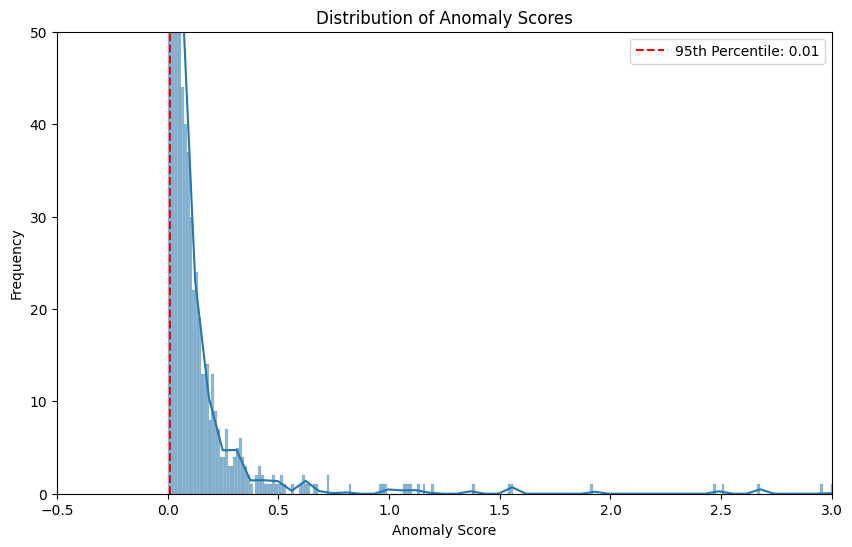

In [ ]:
# 計算 95 百分位異常分數
percentile_95 = np.percentile(df['anomaly_score'], 95)
print(f"95 百分位異常分數值: {percentile_95}")

# 可視化異常分數分佈
plt.figure(figsize=(10, 6))
sns.histplot(df['anomaly_score'], bins=1000, kde=True)
plt.axvline(percentile_95, color='red', linestyle='--', label=f'95th Percentile: {percentile_95:.2f}')
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')

# 自動計算範圍
hist, bin_edges = np.histogram(df['anomaly_score'], bins=1000)
y_max = hist.max()

# 設置 y 軸範圍
# plt.ylim(0, y_max * 1.1)  # 將 y 軸範圍設置為 0 到最大值的 1.1 倍
plt.ylim(0, 50)
plt.xlim(-0.5,3)

# 顯示圖例
plt.legend()

plt.show

### <font color=#4169e1> 05. 使用在 test data 上: 排序前 50 個最高的異常值</font>

In [ ]:
# 定義數據前處理的函數
def new_preprocess_data(df):
    # 移除Unnamed: 0列
    df = df.drop(columns=['Unnamed: 0'])

    # 定義Winsorization方法
    def winsorize_dataframe(df, lower_percentile=0.05, upper_percentile=0.95):
        return df.apply(lambda x: np.clip(x, x.quantile(lower_percentile), x.quantile(upper_percentile)), axis=1)

    # 應用Winsorization到數據框中每個用戶
    df.iloc[:, 1:] = winsorize_dataframe(df.iloc[:, 1:])

    # 定義 Min-Max 標準化方法，針對整個數據集
    def min_max_scale_dataframe(df):
        # 計算最小值和最大值
        min_val = df.min().min()
        max_val = df.max().max()

        # 應用 Min-Max 標準化公式
        df_scaled = (df - min_val) / (max_val - min_val)

        return df_scaled

    # 應用Min-Max標準化到數據框中每個用戶
    df.iloc[:, 1:] = min_max_scale_dataframe(df.iloc[:, 1:])

    return df


# 讀取數據
file_path_new = '/Users/ranli/Documents/python_ve/MS_BDA/weekly_nan_test/df_test_all_recov.csv'
df_new = pd.read_csv(file_path_new)

# 進行數據前處理
df_new = new_preprocess_data(df_new)

# 分離特徵和標籤
X_new = df_new.drop(columns=['CONS_NO'])

# 載入訓練好的CLOF模型
clof = joblib.load('/Users/ranli/Documents/python_ve/MS_BDA/weekly_nan_test/clof_model.joblib')

# 使用模型進行預測
y_new_scores = clof.decision_function(X_new)

# 將異常分數添加到數據框中
df_new['anomaly_score'] = y_new_scores

# 查找異常值最高的前50個CONS_NO並打印其FLAG值和異常分數
new_anomalies_top_50 = df_new.sort_values(by='anomaly_score', ascending=False).head(50)
for cons_no, anomaly_score in zip(new_anomalies_top_50['CONS_NO'], new_anomalies_top_50['anomaly_score']):
    print(f'CONS_NO: {cons_no}, CLOF Score: {anomaly_score}')

CONS_NO: 6267381009A3E393ACED934BA15DC7BF, CLOF Score: 18.515411264745786
CONS_NO: 316E572E18E7281CFF0D79D909B0F997, CLOF Score: 1.9649908971509935
CONS_NO: 38A162FA13963891DA64F421D6C93FE8, CLOF Score: 1.2656751179479375
CONS_NO: 6A12D7551C3734F4898526B7ED06BEAE, CLOF Score: 1.096160145607187
CONS_NO: 2C2AC3D4D288E6EF504C9E3D57D26A61, CLOF Score: 0.3903281082564815
CONS_NO: 33BB72C79623F054914C58A1B44C78F0, CLOF Score: 0.3892850973686749
CONS_NO: AB489592EE54D4BEBB3F5080C9629A04, CLOF Score: 0.35053190649848104
CONS_NO: 9CC9726FD932878E20BAF7C1894F3AF1, CLOF Score: 0.27480132408146146
CONS_NO: 02DCE9A34C5DE855C23F0094A83DC8BB, CLOF Score: 0.22967648717862157
CONS_NO: 16C343E8776BD05C22C467786A1AABBB, CLOF Score: 0.22089785929242592
CONS_NO: 4FD4FE4A48684FD194C6B20AB98F2D74, CLOF Score: 0.21959507913600784
CONS_NO: 6320F65A045BF6F6CA86065666995912, CLOF Score: 0.1996717204767626
CONS_NO: E4F28657D7FF2E2CFAB293181BF8C7B8, CLOF Score: 0.18430196384920683
CONS_NO: 70F42541B916AE085957C5FC

In [ ]:
df_new.shape

(150, 1037)

<font color=#f4a460> 畫圖看異常值分佈 </font>

95 百分位異常分數值: 0.25449514747518276


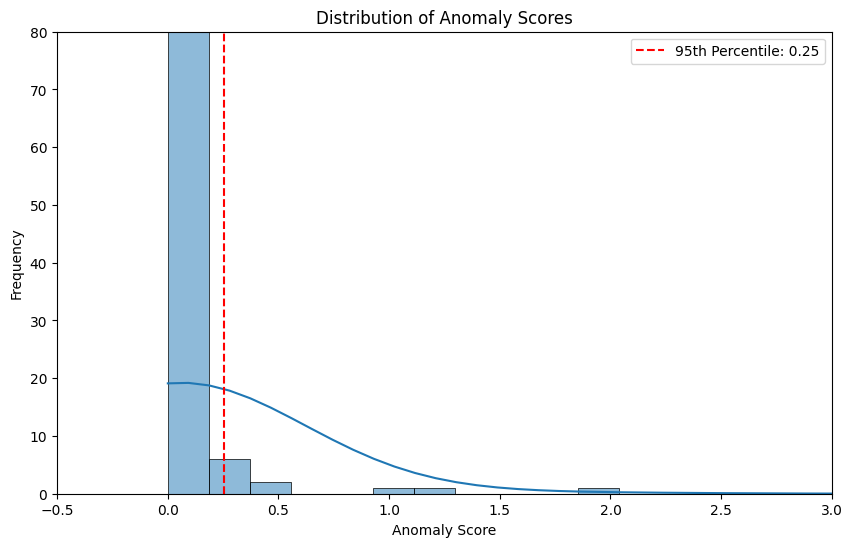

In [ ]:
# 計算 95 百分位異常分數
new_percentile_95 = np.percentile(df_new['anomaly_score'], 95)
print(f"95 百分位異常分數值: {new_percentile_95}")

# 繪製異常分數分佈圖
plt.figure(figsize=(10, 6))
sns.histplot(df_new['anomaly_score'], bins=100, kde=True)
plt.axvline(new_percentile_95, color='red', linestyle='--', label=f'95th Percentile: {new_percentile_95:.2f}')
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')

# 自動計算範圍
hist, bin_edges = np.histogram(df_new['anomaly_score'], bins=100)
y_max = hist.max()

# 設置 y 軸範圍
# plt.ylim(0, y_max * 1.1)  # 將 y 軸範圍設置為 0 到最大值的 1.1 倍
plt.ylim(0, 80)
plt.xlim(-0.5, 3)

# 顯示圖例
plt.legend()

plt.show()